В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle) Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df=pd.read_csv('train.csv')
display(df.head())




,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df.Exited)

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [ ]:
input_cols=list(train_df.drop(columns='Exited'))
target_col = 'Exited'
input_cols, target_col

(['id',
  'CustomerId',
  'Surname',
  'CreditScore',
  'Geography',
  'Gender',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 'Exited')

In [ ]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()


3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [ ]:
numeric_cols=train_inputs.select_dtypes(include=np.number).columns.to_list()
categorical_cols =train_inputs.select_dtypes(exclude=np.number).columns.to_list()
numeric_cols, categorical_cols

(['id',
  'CustomerId',
  'CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 ['Surname', 'Geography', 'Gender'])

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 7180 to 9360
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               12000 non-null  int64  
 1   CustomerId       12000 non-null  float64
 2   Surname          12000 non-null  object 
 3   CreditScore      12000 non-null  float64
 4   Geography        12000 non-null  object 
 5   Gender           12000 non-null  object 
 6   Age              12000 non-null  float64
 7   Tenure           12000 non-null  float64
 8   Balance          12000 non-null  float64
 9   NumOfProducts    12000 non-null  float64
 10  HasCrCard        12000 non-null  float64
 11  IsActiveMember   12000 non-null  float64
 12  EstimatedSalary  12000 non-null  float64
dtypes: float64(9), int64(1), object(3)
memory usage: 1.3+ MB
None


array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'CustomerId'}>,
        <Axes: title={'center': 'CreditScore'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Tenure'}>,
        <Axes: title={'center': 'Balance'}>],
       [<Axes: title={'center': 'NumOfProducts'}>,
        <Axes: title={'center': 'HasCrCard'}>,
        <Axes: title={'center': 'IsActiveMember'}>],
       [<Axes: title={'center': 'EstimatedSalary'}>,
        <Axes: title={'center': 'Exited'}>, <Axes: >]], dtype=object)

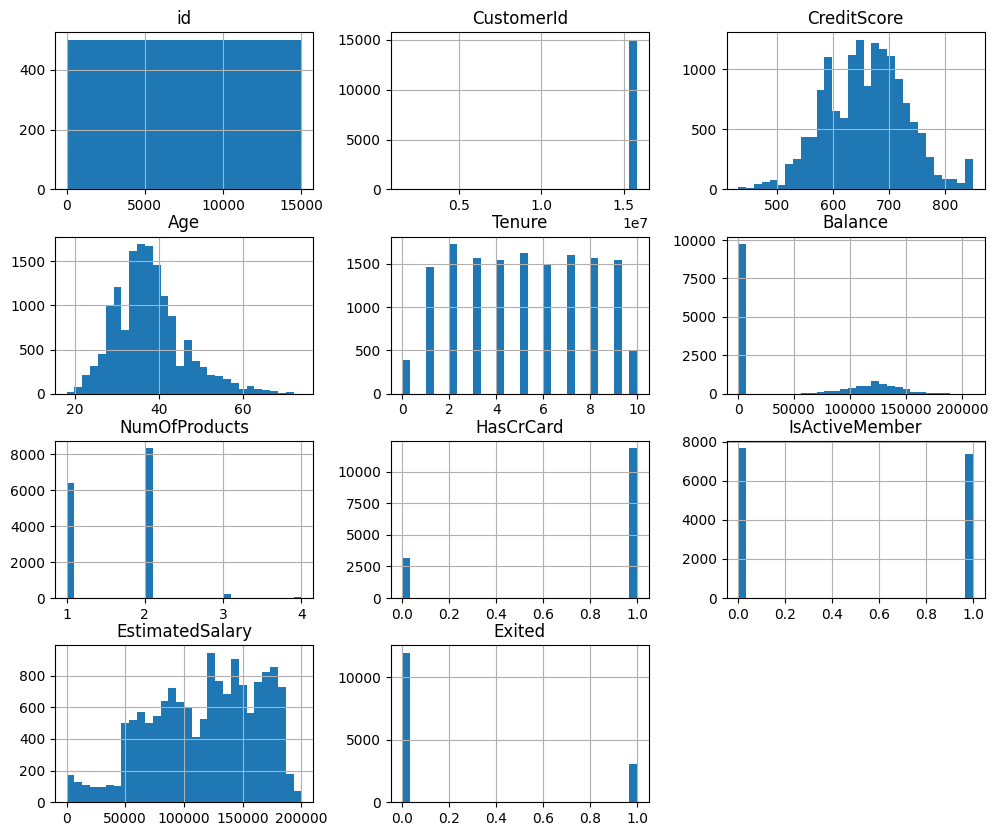

In [ ]:
print(train_inputs.info())
df.hist(figsize=(12, 10), bins=30)

In [ ]:
# 1.  Drop непотрібних колонок 'id', 'CustomerId', 'Surname'

train_inputs=train_inputs.drop(columns=['id', 'CustomerId', 'Surname'])
val_inputs=val_inputs.drop(columns=['id', 'CustomerId', 'Surname'])

In [ ]:
# 2. Додам окрему колонку наявності балансу, так як більшість даних лежить в 0
train_inputs['HasBalance'] = (train_inputs['Balance'] > 0).astype(int)
val_inputs['HasBalance'] = (val_inputs['Balance'] > 0).astype(int)

In [ ]:
# 3. Кодуєммо стать
train_inputs.Gender.value_counts()

,count
Gender,
Male,6876
Female,5124


In [ ]:
is_Male = {'Male': 1, 'Female': 0}
train_inputs['is_Male'] = train_inputs.Gender.map(is_Male)
val_inputs['is_Male'] = val_inputs.Gender.map(is_Male)

In [ ]:
# 4. Кодуєммо Geography
train_inputs.Geography.value_counts()

,count
Geography,
France,7211
Spain,2638
Germany,2151


In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder()
encoder.fit(train_inputs[['Geography']])
encoder.categories_

[array(['France', 'Germany', 'Spain'], dtype=object)]

In [ ]:
one_hot_train = encoder.transform(train_inputs[['Geography']]).toarray()
one_hot_val= encoder.transform(val_inputs[['Geography']]).toarray()

In [ ]:
train_inputs[encoder.categories_[0]]= one_hot_train
val_inputs[encoder.categories_[0]]= one_hot_val

In [ ]:
numeric_cols=train_inputs.select_dtypes(include=np.number).columns.to_list()
categorical_cols =train_inputs.select_dtypes(exclude=np.number).columns.to_list()
numeric_cols, categorical_cols


(['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary',
  'HasBalance',
  'is_Male',
  'France',
  'Germany',
  'Spain'],
 ['Geography', 'Gender'])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
scaler.fit(train_inputs[numeric_cols])

StandardScaler()

In [ ]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [ ]:
train_inputs[numeric_cols].to_parquet('train_inputs.parquet')
val_inputs[numeric_cols].to_parquet('val_inputs.parquet')

train_targets.to_frame().to_parquet('train_targets.parquet')
val_targets.to_frame().to_parquet('val_targets.parquet')


In [ ]:
! ls


log_reg_model_liblinear.joblib	test.csv	       val_inputs.parquet
sample_data			train.csv	       val_targets.parquet
sample_submission.csv		train_inputs.parquet
submission_log_reg.csv		train_targets.parquet


6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [ ]:
X_train=pd.read_parquet('train_inputs.parquet')
X_val=pd.read_parquet('val_inputs.parquet')
y_train =pd.read_parquet('train_targets.parquet')
y_val=pd.read_parquet('val_targets.parquet')

In [ ]:
from sklearn.linear_model import LogisticRegression
model_liblinear = LogisticRegression(solver='saga')

In [ ]:
model_liblinear.fit(X_train, y_train)

LogisticRegression(solver='saga')

In [ ]:
train_preds = model_liblinear.predict(X_train)
train_preds

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
train_preds_val = model_liblinear.predict(X_val)


In [ ]:
train_probs = model_liblinear.predict_proba(X_train)
train_probs

array([[0.98721212, 0.01278788],
       [0.67697156, 0.32302844],
       [0.88287409, 0.11712591],
       ...,
       [0.99361907, 0.00638093],
       [0.83168457, 0.16831543],
       [0.95429859, 0.04570141]])

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, train_preds)

0.87525

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, train_preds, normalize='true')

array([[0.95762712, 0.04237288],
       [0.44717445, 0.55282555]])

In [ ]:
from sklearn.metrics import roc_curve, auc
def compute_auroc_and_build_roc(inputs, targets, name=''):
  # Predict probabilities
  y_pred_proba = model_liblinear.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

AUROC for Training: 0.88


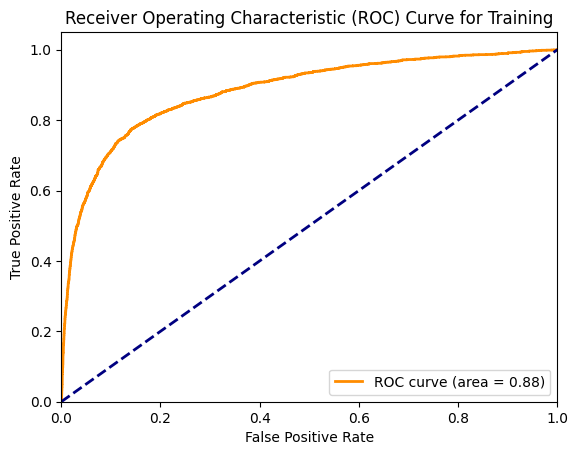

AUROC for Valdation: 0.88


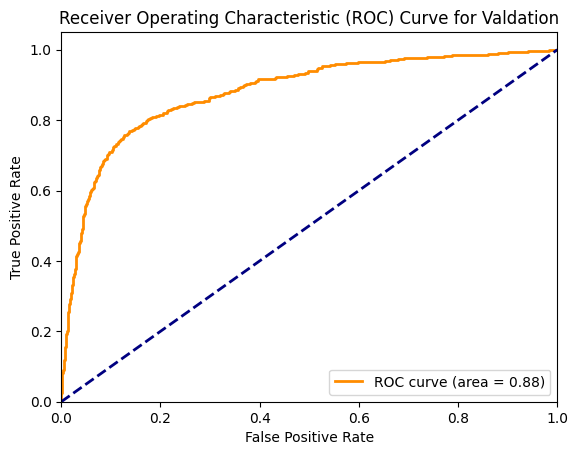

In [ ]:
compute_auroc_and_build_roc(X_train, y_train, 'Training')
compute_auroc_and_build_roc(X_val, y_val, 'Valdation')

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train, train_preds), f1_score(y_val, train_preds_val)


(0.6433166547533953, 0.6414746543778802)

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, model_liblinear.predict_proba(X_train)[:, 1]), roc_auc_score(y_val, model_liblinear.predict_proba(X_val)[:, 1])

(np.float64(0.8827387137179982), np.float64(0.8795575828246107))

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [ ]:
y_train.value_counts()

,count
Exited,
0.0,9558
1.0,2442


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

majority_class = y_train.value_counts().idxmax()

dummy_train_pred = np.full_like(y_train, majority_class)
dummy_valid_pred = np.full_like(y_val, majority_class)
dummy_train_acc = accuracy_score(y_train, dummy_train_pred)
dummy_valid_acc = accuracy_score(y_val, dummy_valid_pred)

dummy_train_acc, dummy_valid_acc

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [ ]:
import joblib
joblib.dump(model_liblinear, "log_reg_model_liblinear.joblib")

['log_reg_model_liblinear.joblib']

In [ ]:
model_2 = joblib.load("log_reg_model_liblinear.joblib")

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, input_df: pd.DataFrame):
    input_df['is_Male'] = input_df.Gender.map(is_Male)
    input_df['HasBalance'] = (input_df['Balance'] > 0).astype(int)
    input_df[encoder.categories_[0]]= encoder.transform(input_df[['Geography']]).toarray()
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])

    X_input = input_df[numeric_cols]
    prob = model_liblinear.predict_proba(X_input)[:,1]
    return prob

In [ ]:
predict_raw_df(scaler, encoder, numeric_cols, df[:5])

array([0.00561519, 0.03383675, 0.37909574, 0.32532025, 0.97774256])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [ ]:
test_raw_df=pd.read_csv('test.csv')

test_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97


In [ ]:
test_raw_df.shape

(10000, 13)

In [ ]:
proba=predict_raw_df(scaler, encoder, numeric_cols, test_raw_df)
test_raw_df['Exited']= (proba >0.5).astype(int)

In [ ]:
test_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,is_Male,HasBalance,France,Germany,Spain,Exited
0,15000,15594796.0,Chu,-1.034678,Germany,Male,-0.944682,-1.087792,1.720173,-1.108193,0.515062,1.016977,0.875226,0.86325,1.356305,-1.227087,2.139813,-0.530827,0
1,15001,15642821.0,Mazzi,-1.490909,France,Male,0.161227,-0.009376,-0.717950,0.769304,0.515062,1.016977,-1.109098,0.86325,-0.737297,0.814938,-0.467331,-0.530827,0
2,15002,15716284.0,Onyekachi,0.651991,France,Male,0.652742,1.069040,-0.717950,0.769304,0.515062,-0.983306,0.850584,0.86325,-0.737297,0.814938,-0.467331,-0.530827,0
3,15003,15785078.0,Martin,0.804068,Spain,Male,0.898500,-0.728320,-0.717950,-1.108193,0.515062,1.016977,1.073044,0.86325,-0.737297,-1.227087,-0.467331,1.883853,0
4,15004,15662955.0,Kenechukwu,-0.924077,Spain,Male,0.652742,1.069040,-0.717950,0.769304,0.515062,1.016977,0.563521,0.86325,-0.737297,-1.227087,-0.467331,1.883853,0


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [ ]:
df_final=pd.read_csv('sample_submission.csv')
df_final.head()


,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5


In [ ]:
a=df_final['id']==test_raw_df['id']
a.sum()

np.int64(10000)

In [ ]:
df_final['Exited'].sum()

np.float64(5000.0)

In [ ]:
df_final['Exited']=test_raw_df['Exited']

In [ ]:
df_final['Exited'].sum()

np.int64(1570)

,id,Exited
0,15000,0
1,15001,0
2,15002,0
3,15003,0
4,15004,0


In [ ]:
df_final.to_csv("submission_log_reg.csv", index=False)